## Install

``` shell
conda create python=2.7 h5py jupyter -p ~/space/envs/peaknet
conda install pytorch=0.1.12 torchvision cuda80 -c pytorch
conda install tensorboardX
```


### Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import numpy as np
import time
from peaknet import Peaknet
from peaknet_utils import *

/reg/neh/home/liponan/space/envs/peaknet/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load data from CXI

('imgs', (1, 32, 185, 388))
('labels', 6, 454)


### Init. network

In [3]:
net = Peaknet()
net.loadCfg( "../pytorch-yolo2/cfg/newpeaksv10-asic.cfg" )
# net.init_model()
net.loadWeights( "../pytorch-yolo2/cfg/newpeaksv10-asic.cfg", 
                "../darknet/backup/newpeaksv10_10000.weights")
net.model.cuda()

Darknet (
  (models): ModuleList (
    (0): Sequential (
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (leaky1): LeakyReLU (0.1, inplace)
    )
    (1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (2): Sequential (
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (leaky2): LeakyReLU (0.1, inplace)
    )
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Sequential (
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (leaky3): LeakyReLU (0.1, inplace)
    )
    (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Sequential (
      (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(

## Train

### Dataset

In [17]:
filename = "/reg/neh/home/liponan/data/cxic0415/r0091/cxic0415_0091.cxi.backup"
t0 = time.time()
train_imgs, train_labels, dev_imgs, dev_labels = build_dataset( filename, dev_size = 100, total_size=-1 )
t1 = time.time()
print("took " + str(t1-t0) + " s to build the datasets")
print("train_imgs", train_imgs.shape)
print("train_labels", len(train_labels), len(train_labels[0]))
print("dev_imgs", dev_imgs.shape)
print("dev_labels", len(dev_labels), len(dev_labels[0]))

hits: 1325
took 614.173167944 s to build the datasets
('train_imgs', (1225, 32, 185, 388))
('train_labels', 1225, 6)
('dev_imgs', (100, 32, 185, 388))
('dev_labels', 100, 6)


### Confg

In [76]:
project_name = "runs/adagrad_lr_001_pretrained_40000_nooptim"
n_ep = 1
init_lr = 0.01
lr_policy = 1
macro_batch_size = 4
algo = "adagrad"

params = {"n_ep":n_ep, "lr": init_lr, "batch_size":macro_batch_size, "lr_policy": lr_policy, 
          "train_size": len(train_labels), "optim": algo}

net = Peaknet()
net.loadCfg( "../pytorch-yolo2/cfg/newpeaksv10-asic.cfg" )
net.loadWeights( "../pytorch-yolo2/cfg/newpeaksv10-asic.cfg", 
                "../darknet/backup/newpeaksv10_40000.weights")
# net.init_model()
net.model.cuda()

Darknet (
  (models): ModuleList (
    (0): Sequential (
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (leaky1): LeakyReLU (0.1, inplace)
    )
    (1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (2): Sequential (
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (leaky2): LeakyReLU (0.1, inplace)
    )
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Sequential (
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (leaky3): LeakyReLU (0.1, inplace)
    )
    (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Sequential (
      (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(

In [77]:
n_iters = int( np.ceil( len(train_labels) / float(macro_batch_size) ) )
net.set_writer(project_name=project_name, parameters=params)
my_lr = init_lr

for ep in range(1, n_ep+1):
    print("============= EPOCH {} ==========".format(ep))
    if ep % lr_policy == 0:
        my_lr /= 2
    for i in range(n_iters):
        if i == (n_iters-1):
            batch_imgs = train_imgs[(i*macro_batch_size):,:,:,:]
            batch_labels = train_labels[(i*macro_batch_size):]
        else:
            batch_imgs = train_imgs[i*macro_batch_size:(i+1)*macro_batch_size,:,:,:]
            batch_labels = train_labels[i*macro_batch_size:(i+1)*macro_batch_size]
        net.train( batch_imgs, batch_labels, batch_size=32 )
        #net.set_optimizer(adagrad=(algo=="adagrad"), lr=my_lr )
        #net.optimize()

============= EPOCH 1 ==========
1280032: nGT 16, recall 0, proposals 35, loss: x 0.081966, y 0.030712, w 0.481800, h 0.597398, conf 5.781363, cls 0.000000, total 6.973240
1280064: nGT 194, recall 0, proposals 148, loss: x 1.153800, y 0.580795, w 5.265344, h 6.934127, conf 19.338537, cls 0.000000, total 33.272602
1280096: nGT 69, recall 0, proposals 81, loss: x 0.366980, y 0.254036, w 2.314975, h 2.762507, conf 11.442594, cls 0.000000, total 17.141094
1280128: nGT 28, recall 0, proposals 30, loss: x 0.167166, y 0.065976, w 1.170853, h 1.158773, conf 5.991827, cls 0.000000, total 8.554596
1280160: nGT 29, recall 0, proposals 47, loss: x 0.090221, y 0.061317, w 0.941854, h 1.165435, conf 7.771359, cls 0.000000, total 10.030187
1280192: nGT 78, recall 2, proposals 97, loss: x 0.192578, y 0.167384, w 1.888172, h 2.637778, conf 11.639734, cls 0.000000, total 16.525644
1280224: nGT 51, recall 1, proposals 78, loss: x 0.127176, y 0.102392, w 1.533269, h 1.919358, conf 12.998139, cls 0.000000,

1281920: nGT 47, recall 0, proposals 68, loss: x 0.114804, y 0.102111, w 1.404351, h 1.726598, conf 9.924239, cls 0.000000, total 13.272103
1281952: nGT 39, recall 0, proposals 65, loss: x 0.122844, y 0.039302, w 1.093928, h 1.345544, conf 10.801965, cls 0.000000, total 13.403584
1281984: nGT 227, recall 0, proposals 160, loss: x 0.758388, y 0.628625, w 5.753572, h 8.092958, conf 22.909338, cls 0.000000, total 38.142883
1282016: nGT 23, recall 1, proposals 35, loss: x 0.058898, y 0.039744, w 0.743875, h 0.944814, conf 6.825302, cls 0.000000, total 8.612635
1282048: nGT 35, recall 0, proposals 57, loss: x 0.110678, y 0.064629, w 0.853360, h 1.154183, conf 9.430313, cls 0.000000, total 11.613163
1282080: nGT 100, recall 0, proposals 139, loss: x 0.417466, y 0.269314, w 2.643560, h 3.523370, conf 9.865600, cls 0.000000, total 16.719311
1282112: nGT 20, recall 1, proposals 36, loss: x 0.101471, y 0.078526, w 0.451794, h 0.714936, conf 7.073184, cls 0.000000, total 8.419911
1282144: nGT 21,

1283808: nGT 44, recall 0, proposals 74, loss: x 0.153719, y 0.085625, w 1.062560, h 1.430899, conf 9.287524, cls 0.000000, total 12.020327
1283840: nGT 29, recall 1, proposals 48, loss: x 0.151021, y 0.059300, w 1.038889, h 1.091951, conf 7.257160, cls 0.000000, total 9.598321
1283872: nGT 31, recall 0, proposals 36, loss: x 0.169801, y 0.459477, w 1.270057, h 1.126396, conf 5.940306, cls 0.000000, total 8.966037
1283904: nGT 98, recall 0, proposals 99, loss: x 0.266260, y 0.214520, w 2.534817, h 3.285127, conf 9.862452, cls 0.000000, total 16.163176
1283936: nGT 72, recall 0, proposals 86, loss: x 0.270454, y 0.112963, w 1.840260, h 2.557950, conf 8.999646, cls 0.000000, total 13.781272
1283968: nGT 27, recall 0, proposals 42, loss: x 0.338317, y 0.089568, w 0.934482, h 0.997087, conf 6.684621, cls 0.000000, total 9.044075
1284000: nGT 84, recall 1, proposals 97, loss: x 0.248799, y 0.197781, w 2.478578, h 2.836353, conf 9.692960, cls 0.000000, total 15.454472
1284032: nGT 36, recall

1285728: nGT 18, recall 0, proposals 22, loss: x 0.041686, y 0.023747, w 0.824797, h 0.814395, conf 4.241333, cls 0.000000, total 5.945958
1285760: nGT 43, recall 1, proposals 60, loss: x 0.118511, y 0.068072, w 1.034387, h 1.380716, conf 8.708507, cls 0.000000, total 11.310191
1285792: nGT 123, recall 1, proposals 120, loss: x 0.572171, y 0.414405, w 3.116978, h 4.174213, conf 12.264996, cls 0.000000, total 20.542763
1285824: nGT 138, recall 1, proposals 148, loss: x 0.481897, y 0.333109, w 3.346814, h 4.744501, conf 13.644857, cls 0.000000, total 22.551178
1285856: nGT 83, recall 1, proposals 106, loss: x 0.239039, y 0.418313, w 2.303956, h 2.917476, conf 11.869509, cls 0.000000, total 17.748293
1285888: nGT 22, recall 0, proposals 46, loss: x 0.105419, y 0.021772, w 0.835688, h 0.832121, conf 8.112075, cls 0.000000, total 9.907076
1285920: nGT 16, recall 0, proposals 36, loss: x 0.032338, y 0.022640, w 0.563308, h 0.642796, conf 6.377012, cls 0.000000, total 7.638094
1285952: nGT 13

1287616: nGT 22, recall 1, proposals 35, loss: x 0.054346, y 0.048715, w 0.623454, h 0.811504, conf 6.306044, cls 0.000000, total 7.844063
1287648: nGT 17, recall 0, proposals 19, loss: x 0.052743, y 0.025989, w 0.567734, h 0.688200, conf 4.568259, cls 0.000000, total 5.902924
1287680: nGT 35, recall 0, proposals 51, loss: x 0.110303, y 0.043377, w 0.978094, h 1.249853, conf 8.663247, cls 0.000000, total 11.044874
1287712: nGT 15, recall 0, proposals 33, loss: x 0.057759, y 0.013737, w 0.443000, h 0.551735, conf 5.309271, cls 0.000000, total 6.375503
1287744: nGT 50, recall 3, proposals 65, loss: x 0.219383, y 0.091103, w 1.295394, h 1.752780, conf 8.737648, cls 0.000000, total 12.096308
1287776: nGT 62, recall 0, proposals 87, loss: x 0.207260, y 0.159014, w 1.756221, h 2.229089, conf 12.482165, cls 0.000000, total 16.833750
1287808: nGT 18, recall 1, proposals 23, loss: x 0.048370, y 0.025434, w 0.400977, h 0.606794, conf 5.915107, cls 0.000000, total 6.996683
1287840: nGT 66, recall

1289504: nGT 71, recall 0, proposals 82, loss: x 0.192183, y 0.114989, w 2.221105, h 2.443379, conf 10.288829, cls 0.000000, total 15.260485
1289536: nGT 14, recall 0, proposals 35, loss: x 0.051471, y 0.043191, w 0.367442, h 0.556241, conf 7.671842, cls 0.000000, total 8.690187
1289568: nGT 87, recall 0, proposals 104, loss: x 0.294221, y 0.307669, w 2.111636, h 2.951000, conf 11.032957, cls 0.000000, total 16.697483
1289600: nGT 15, recall 0, proposals 26, loss: x 0.046560, y 0.022380, w 0.690805, h 0.600092, conf 5.630101, cls 0.000000, total 6.989938
1289632: nGT 78, recall 0, proposals 101, loss: x 0.249601, y 0.129083, w 2.652693, h 3.180866, conf 10.091263, cls 0.000000, total 16.303507
1289664: nGT 21, recall 1, proposals 29, loss: x 0.046609, y 0.051381, w 0.637399, h 0.796709, conf 6.227519, cls 0.000000, total 7.759616
1289696: nGT 104, recall 0, proposals 110, loss: x 0.320446, y 0.243404, w 2.461130, h 3.392422, conf 10.864183, cls 0.000000, total 17.281586
1289728: nGT 82

1291424: nGT 33, recall 1, proposals 40, loss: x 0.107290, y 0.099545, w 1.004070, h 1.224813, conf 6.306838, cls 0.000000, total 8.742556
1291456: nGT 35, recall 2, proposals 51, loss: x 0.138594, y 0.084251, w 0.804789, h 1.166181, conf 7.539578, cls 0.000000, total 9.733393
1291488: nGT 118, recall 1, proposals 135, loss: x 0.368883, y 0.236103, w 3.323884, h 4.300526, conf 10.934783, cls 0.000000, total 19.164179
1291520: nGT 18, recall 0, proposals 41, loss: x 0.052351, y 0.024995, w 0.812810, h 0.822104, conf 8.598601, cls 0.000000, total 10.310863
1291552: nGT 50, recall 1, proposals 55, loss: x 0.107374, y 0.088173, w 1.610731, h 1.768136, conf 9.255044, cls 0.000000, total 12.829459
1291584: nGT 42, recall 0, proposals 70, loss: x 0.106151, y 0.085768, w 1.078346, h 1.398486, conf 9.455537, cls 0.000000, total 12.124288
1291616: nGT 68, recall 1, proposals 99, loss: x 0.249965, y 0.391970, w 1.852548, h 2.577746, conf 12.103915, cls 0.000000, total 17.176144
1291648: nGT 30, r

1293376: nGT 76, recall 0, proposals 79, loss: x 0.198992, y 0.158065, w 2.320084, h 2.830791, conf 10.797278, cls 0.000000, total 16.305210
1293408: nGT 118, recall 1, proposals 114, loss: x 0.323127, y 0.323121, w 3.432755, h 4.233026, conf 11.857060, cls 0.000000, total 20.169088
1293440: nGT 117, recall 1, proposals 115, loss: x 0.620020, y 0.372260, w 3.152915, h 4.104597, conf 11.042716, cls 0.000000, total 19.292507
1293472: nGT 80, recall 0, proposals 90, loss: x 0.244008, y 0.254739, w 2.283202, h 2.757239, conf 10.660234, cls 0.000000, total 16.199421
1293504: nGT 12, recall 1, proposals 26, loss: x 0.106082, y 0.036244, w 0.467037, h 0.435578, conf 5.486791, cls 0.000000, total 6.531733
1293536: nGT 60, recall 0, proposals 80, loss: x 0.158732, y 0.135766, w 1.698181, h 2.172119, conf 7.685585, cls 0.000000, total 11.850384
1293568: nGT 14, recall 1, proposals 25, loss: x 0.032357, y 0.039702, w 0.385098, h 0.452834, conf 5.280859, cls 0.000000, total 6.190849
1293600: nGT 4

1295264: nGT 30, recall 1, proposals 40, loss: x 0.120666, y 0.077946, w 1.062069, h 1.152258, conf 6.542899, cls 0.000000, total 8.955838
1295296: nGT 146, recall 3, proposals 146, loss: x 0.458718, y 0.469119, w 3.606720, h 5.317781, conf 12.062005, cls 0.000000, total 21.914345
1295328: nGT 86, recall 1, proposals 98, loss: x 0.241543, y 0.117218, w 2.167114, h 2.886005, conf 8.861419, cls 0.000000, total 14.273299
1295360: nGT 63, recall 0, proposals 96, loss: x 0.263864, y 0.189326, w 1.666793, h 2.187191, conf 12.978203, cls 0.000000, total 17.285378
1295392: nGT 30, recall 0, proposals 32, loss: x 0.095362, y 0.092691, w 1.185998, h 1.138358, conf 7.572609, cls 0.000000, total 10.085019
1295424: nGT 12, recall 0, proposals 28, loss: x 0.030329, y 0.014739, w 0.300430, h 0.372823, conf 6.110680, cls 0.000000, total 6.829002
1295456: nGT 53, recall 0, proposals 88, loss: x 0.118281, y 0.089839, w 1.246397, h 1.914377, conf 12.060760, cls 0.000000, total 15.429653
1295488: nGT 63, 

1297184: nGT 100, recall 0, proposals 121, loss: x 0.265556, y 0.238377, w 2.519440, h 3.419977, conf 11.271564, cls 0.000000, total 17.714912
1297216: nGT 22, recall 0, proposals 43, loss: x 0.079457, y 0.090973, w 0.543109, h 0.770488, conf 8.290536, cls 0.000000, total 9.774564
1297248: nGT 31, recall 1, proposals 52, loss: x 0.104847, y 0.056449, w 0.787734, h 1.080410, conf 8.633715, cls 0.000000, total 10.663155
1297280: nGT 86, recall 2, proposals 99, loss: x 0.220067, y 0.144041, w 2.092400, h 2.802060, conf 8.596559, cls 0.000000, total 13.855125
1297312: nGT 46, recall 2, proposals 70, loss: x 0.109824, y 0.081103, w 1.126722, h 1.508878, conf 9.176835, cls 0.000000, total 12.003363
1297344: nGT 15, recall 0, proposals 28, loss: x 0.026542, y 0.023073, w 0.552332, h 0.560534, conf 5.404962, cls 0.000000, total 6.567443
1297376: nGT 22, recall 1, proposals 24, loss: x 0.053228, y 0.030905, w 0.703711, h 0.905617, conf 6.474115, cls 0.000000, total 8.167576
1297408: nGT 98, rec

1299072: nGT 54, recall 0, proposals 78, loss: x 0.139744, y 0.075475, w 1.764455, h 1.984385, conf 10.507163, cls 0.000000, total 14.471222
1299104: nGT 108, recall 1, proposals 129, loss: x 0.375013, y 0.216590, w 2.317957, h 3.503733, conf 8.858924, cls 0.000000, total 15.272218
1299136: nGT 77, recall 0, proposals 90, loss: x 0.238872, y 0.155421, w 1.942868, h 2.740623, conf 8.825201, cls 0.000000, total 13.902987
1299168: nGT 70, recall 0, proposals 95, loss: x 0.220505, y 0.117445, w 1.668987, h 2.232515, conf 11.338455, cls 0.000000, total 15.577908
1299200: nGT 55, recall 0, proposals 79, loss: x 0.161516, y 0.093621, w 1.786982, h 2.080914, conf 10.713476, cls 0.000000, total 14.836511
1299232: nGT 190, recall 1, proposals 152, loss: x 1.017558, y 0.648386, w 5.103518, h 6.637582, conf 17.159025, cls 0.000000, total 30.566069
1299264: nGT 43, recall 0, proposals 67, loss: x 0.072369, y 0.059760, w 1.056630, h 1.353181, conf 10.709193, cls 0.000000, total 13.251133
1299296: nG

1300992: nGT 119, recall 0, proposals 136, loss: x 0.374393, y 0.268010, w 3.008926, h 4.322340, conf 10.454803, cls 0.000000, total 18.428473
1301024: nGT 33, recall 0, proposals 53, loss: x 0.058267, y 0.047231, w 1.155500, h 1.235381, conf 10.301164, cls 0.000000, total 12.797544
1301056: nGT 31, recall 1, proposals 60, loss: x 0.109113, y 0.036629, w 1.191047, h 1.166123, conf 9.671148, cls 0.000000, total 12.174060
1301088: nGT 129, recall 0, proposals 132, loss: x 0.472834, y 0.459177, w 3.523773, h 4.542961, conf 13.524914, cls 0.000000, total 22.523659
1301120: nGT 73, recall 1, proposals 99, loss: x 0.220776, y 0.142516, w 1.938576, h 2.412054, conf 12.320689, cls 0.000000, total 17.034611
1301152: nGT 22, recall 1, proposals 39, loss: x 0.236404, y 0.025574, w 0.464669, h 0.683249, conf 7.152715, cls 0.000000, total 8.562611
1301184: nGT 67, recall 0, proposals 75, loss: x 0.381962, y 0.204318, w 2.191784, h 2.444721, conf 11.678731, cls 0.000000, total 16.901516
1301216: nGT

1302912: nGT 30, recall 1, proposals 52, loss: x 0.114455, y 0.063900, w 0.716475, h 0.953288, conf 8.378728, cls 0.000000, total 10.226847
1302944: nGT 36, recall 0, proposals 59, loss: x 0.275630, y 0.139236, w 0.938692, h 1.303745, conf 9.920106, cls 0.000000, total 12.577410
1302976: nGT 96, recall 1, proposals 110, loss: x 0.270675, y 0.251083, w 2.336926, h 3.335430, conf 11.385237, cls 0.000000, total 17.579350
1303008: nGT 53, recall 0, proposals 88, loss: x 0.239663, y 0.244820, w 1.226701, h 1.743499, conf 10.764777, cls 0.000000, total 14.219460
1303040: nGT 34, recall 1, proposals 37, loss: x 0.093291, y 0.047946, w 1.159846, h 1.330222, conf 6.163698, cls 0.000000, total 8.795002
1303072: nGT 86, recall 1, proposals 106, loss: x 0.337066, y 0.216744, w 2.116584, h 3.035469, conf 11.411839, cls 0.000000, total 17.117702
1303104: nGT 11, recall 1, proposals 23, loss: x 0.034570, y 0.016686, w 0.249852, h 0.336220, conf 5.760986, cls 0.000000, total 6.398314
1303136: nGT 16, 

1304800: nGT 37, recall 0, proposals 58, loss: x 0.135862, y 0.085100, w 1.259404, h 1.398815, conf 8.661926, cls 0.000000, total 11.541107
1304832: nGT 18, recall 0, proposals 43, loss: x 0.076260, y 0.039725, w 0.511843, h 0.573077, conf 8.598300, cls 0.000000, total 9.799205
1304864: nGT 64, recall 0, proposals 84, loss: x 0.223339, y 0.119154, w 1.718789, h 2.024624, conf 9.823387, cls 0.000000, total 13.909293
1304896: nGT 13, recall 0, proposals 20, loss: x 0.017341, y 0.023317, w 0.347956, h 0.446359, conf 4.674258, cls 0.000000, total 5.509233
1304928: nGT 83, recall 1, proposals 95, loss: x 0.449283, y 0.189624, w 2.595109, h 3.025954, conf 11.009806, cls 0.000000, total 17.269777
1304960: nGT 51, recall 1, proposals 68, loss: x 0.145639, y 0.117124, w 1.271265, h 1.725965, conf 11.717517, cls 0.000000, total 14.977510
1304992: nGT 19, recall 0, proposals 30, loss: x 0.073082, y 0.043242, w 0.698502, h 0.780491, conf 6.031295, cls 0.000000, total 7.626612
1305024: nGT 45, reca

1306720: nGT 17, recall 0, proposals 34, loss: x 0.075383, y 0.018915, w 0.469107, h 0.708597, conf 6.311213, cls 0.000000, total 7.583217
1306752: nGT 70, recall 3, proposals 69, loss: x 0.208860, y 0.121826, w 2.113902, h 2.329973, conf 8.898671, cls 0.000000, total 13.673232
1306784: nGT 36, recall 0, proposals 56, loss: x 0.105143, y 0.096308, w 0.824296, h 1.334284, conf 10.884274, cls 0.000000, total 13.244306
1306816: nGT 72, recall 1, proposals 99, loss: x 0.220519, y 0.169585, w 1.720001, h 2.349806, conf 10.839286, cls 0.000000, total 15.299198
1306848: nGT 17, recall 0, proposals 22, loss: x 0.048351, y 0.043339, w 0.602501, h 0.605286, conf 4.191601, cls 0.000000, total 5.491078
1306880: nGT 79, recall 0, proposals 96, loss: x 0.479012, y 0.323948, w 2.199266, h 2.809880, conf 8.810156, cls 0.000000, total 14.622261
1306912: nGT 59, recall 1, proposals 81, loss: x 0.218667, y 0.099413, w 1.676913, h 2.062066, conf 11.611961, cls 0.000000, total 15.669020
1306944: nGT 17, re

1308640: nGT 25, recall 0, proposals 41, loss: x 0.081920, y 0.030201, w 0.957596, h 1.009113, conf 8.538807, cls 0.000000, total 10.617637
1308672: nGT 17, recall 0, proposals 40, loss: x 0.063994, y 0.041215, w 0.792500, h 0.763353, conf 7.398731, cls 0.000000, total 9.059793
1308704: nGT 105, recall 0, proposals 114, loss: x 0.608781, y 0.226481, w 2.995392, h 3.851288, conf 10.057291, cls 0.000000, total 17.739233
1308736: nGT 15, recall 1, proposals 37, loss: x 0.029316, y 0.019110, w 0.308387, h 0.437300, conf 6.681782, cls 0.000000, total 7.475894
1308768: nGT 25, recall 0, proposals 40, loss: x 0.064189, y 0.050918, w 0.824056, h 0.956288, conf 8.300147, cls 0.000000, total 10.195599
1308800: nGT 30, recall 0, proposals 44, loss: x 0.082807, y 0.091609, w 1.038718, h 1.141465, conf 8.270481, cls 0.000000, total 10.625080
1308832: nGT 27, recall 0, proposals 39, loss: x 0.037102, y 0.082656, w 0.861149, h 0.983111, conf 7.184940, cls 0.000000, total 9.148958
1308864: nGT 51, rec

1310528: nGT 39, recall 1, proposals 82, loss: x 0.140306, y 0.056528, w 1.038409, h 1.381161, conf 11.953121, cls 0.000000, total 14.569525
1310560: nGT 109, recall 0, proposals 128, loss: x 0.281262, y 0.212970, w 2.690061, h 3.620144, conf 11.441781, cls 0.000000, total 18.246218
1310592: nGT 66, recall 1, proposals 97, loss: x 0.168468, y 0.112793, w 1.557121, h 2.178042, conf 9.340856, cls 0.000000, total 13.357279
1310624: nGT 65, recall 2, proposals 89, loss: x 0.281461, y 0.128594, w 1.406185, h 2.160231, conf 8.687759, cls 0.000000, total 12.664230
1310656: nGT 17, recall 1, proposals 22, loss: x 0.042486, y 0.020634, w 0.505851, h 0.685650, conf 6.174178, cls 0.000000, total 7.428799
1310688: nGT 19, recall 0, proposals 19, loss: x 0.044646, y 0.044358, w 0.790635, h 0.810400, conf 4.015376, cls 0.000000, total 5.705415
1310720: nGT 63, recall 0, proposals 91, loss: x 0.165902, y 0.122395, w 1.404476, h 2.129463, conf 10.655306, cls 0.000000, total 14.477541
1310752: nGT 66, 

1312448: nGT 34, recall 1, proposals 50, loss: x 0.086053, y 0.059221, w 0.965332, h 1.285699, conf 8.408228, cls 0.000000, total 10.804533
1312480: nGT 54, recall 0, proposals 79, loss: x 0.138272, y 0.071890, w 1.372661, h 1.827851, conf 10.341769, cls 0.000000, total 13.752442
1312512: nGT 66, recall 0, proposals 75, loss: x 0.169420, y 0.117502, w 1.944085, h 2.414126, conf 9.660558, cls 0.000000, total 14.305692
1312544: nGT 100, recall 0, proposals 104, loss: x 0.343899, y 0.253339, w 2.408239, h 3.411382, conf 9.517934, cls 0.000000, total 15.934793
1312576: nGT 15, recall 0, proposals 28, loss: x 0.034753, y 0.034984, w 0.336508, h 0.465213, conf 5.464535, cls 0.000000, total 6.335993
1312608: nGT 24, recall 1, proposals 41, loss: x 0.212736, y 0.029627, w 0.762359, h 0.961441, conf 8.074059, cls 0.000000, total 10.040223
1312640: nGT 16, recall 0, proposals 23, loss: x 0.029521, y 0.044670, w 0.410620, h 0.544746, conf 5.332029, cls 0.000000, total 6.361587
1312672: nGT 12, re

1314336: nGT 97, recall 3, proposals 120, loss: x 0.230162, y 0.174112, w 2.200753, h 3.185523, conf 9.507717, cls 0.000000, total 15.298267
1314368: nGT 87, recall 0, proposals 89, loss: x 0.233866, y 0.177159, w 2.432542, h 3.143310, conf 9.497760, cls 0.000000, total 15.484638
1314400: nGT 99, recall 0, proposals 102, loss: x 0.435802, y 0.289599, w 2.822472, h 3.520076, conf 13.246490, cls 0.000000, total 20.314438
1314432: nGT 108, recall 2, proposals 121, loss: x 0.321147, y 0.253966, w 2.630296, h 3.558686, conf 11.543365, cls 0.000000, total 18.307459
1314464: nGT 57, recall 0, proposals 81, loss: x 0.292149, y 0.147556, w 1.415708, h 1.917011, conf 8.968997, cls 0.000000, total 12.741422
1314496: nGT 125, recall 2, proposals 141, loss: x 0.322607, y 0.256754, w 3.111501, h 4.157738, conf 9.801237, cls 0.000000, total 17.649837
1314528: nGT 25, recall 0, proposals 30, loss: x 0.109945, y 0.041823, w 1.043981, h 1.097535, conf 7.409738, cls 0.000000, total 9.703022
1314560: nGT 

1316256: nGT 47, recall 1, proposals 68, loss: x 0.145027, y 0.217218, w 1.720496, h 1.935651, conf 11.291240, cls 0.000000, total 15.309631
1316288: nGT 12, recall 0, proposals 30, loss: x 0.024819, y 0.023018, w 0.204889, h 0.359066, conf 6.342548, cls 0.000000, total 6.954340
1316320: nGT 18, recall 0, proposals 27, loss: x 0.086642, y 0.081013, w 0.652554, h 0.766261, conf 5.591063, cls 0.000000, total 7.177533
1316352: nGT 4, recall 0, proposals 25, loss: x 0.015401, y 0.005214, w 0.086310, h 0.140683, conf 5.073785, cls 0.000000, total 5.321393
1316384: nGT 17, recall 1, proposals 28, loss: x 0.061629, y 0.033511, w 0.611573, h 0.589391, conf 5.894679, cls 0.000000, total 7.190784
1316416: nGT 87, recall 2, proposals 121, loss: x 0.191871, y 0.191263, w 1.945415, h 2.983326, conf 9.480330, cls 0.000000, total 14.792206
1316448: nGT 42, recall 0, proposals 66, loss: x 0.175658, y 0.134996, w 1.084018, h 1.452440, conf 9.535024, cls 0.000000, total 12.382134
1316480: nGT 61, recall

1318144: nGT 26, recall 0, proposals 33, loss: x 0.068468, y 0.047414, w 0.718989, h 0.872013, conf 6.980680, cls 0.000000, total 8.687563
1318176: nGT 14, recall 0, proposals 21, loss: x 0.020103, y 0.022246, w 0.599082, h 0.580691, conf 3.615516, cls 0.000000, total 4.837638
1318208: nGT 95, recall 1, proposals 126, loss: x 0.364995, y 0.249467, w 2.200918, h 3.372517, conf 9.485328, cls 0.000000, total 15.673225
1318240: nGT 147, recall 0, proposals 135, loss: x 0.659208, y 0.443887, w 4.340159, h 5.201694, conf 14.750887, cls 0.000000, total 25.395836
1318272: nGT 41, recall 1, proposals 78, loss: x 0.104305, y 0.061895, w 1.372825, h 1.504771, conf 9.130956, cls 0.000000, total 12.174752
1318304: nGT 40, recall 0, proposals 59, loss: x 0.118453, y 0.070429, w 1.003427, h 1.391348, conf 8.249732, cls 0.000000, total 10.833390
1318336: nGT 23, recall 2, proposals 31, loss: x 0.050708, y 0.025149, w 0.721838, h 0.865551, conf 5.533384, cls 0.000000, total 7.196630
1318368: nGT 26, re

## Predict

In [14]:
filename = "/reg/neh/home/liponan/data/cxic0415/r0091/cxic0415_0091.cxi.backup"
idx=468
imgs, labels = imgs, labels = load_from_cxi( filename, idx )
print("imgs", imgs.shape)
print("labels", len(labels), len(labels[0]))

('imgs', (1, 32, 185, 388))
('labels', 6, 454)


In [78]:
results = net.predict( imgs, batch_size=32, conf_thresh=0.10, use_cuda=True )


In [79]:
print((results[14]))

[[0.94130091764489, 0.08675289154052734, 0.029913804969009087, 0.05957833925882975, 0.1886216700077057, 1.0, 0]]


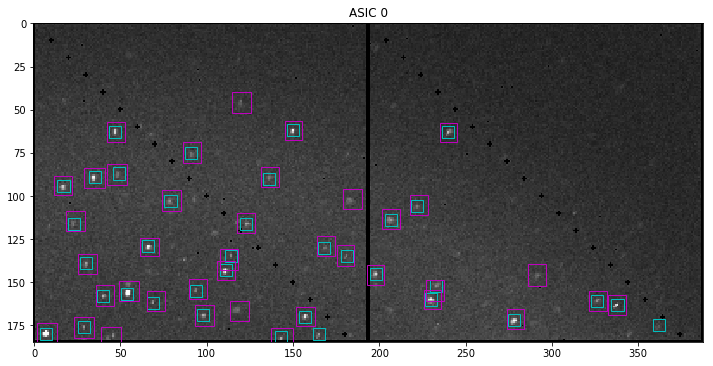

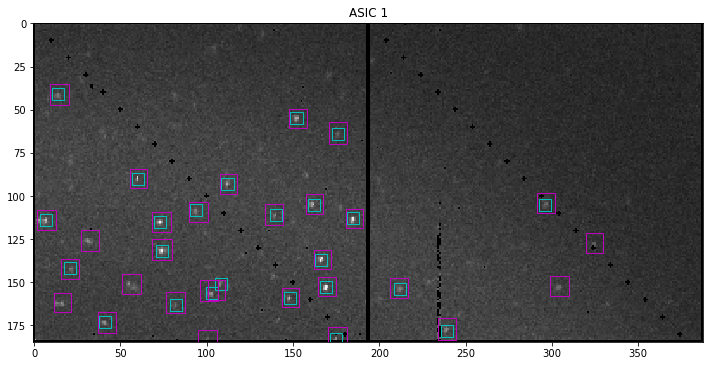

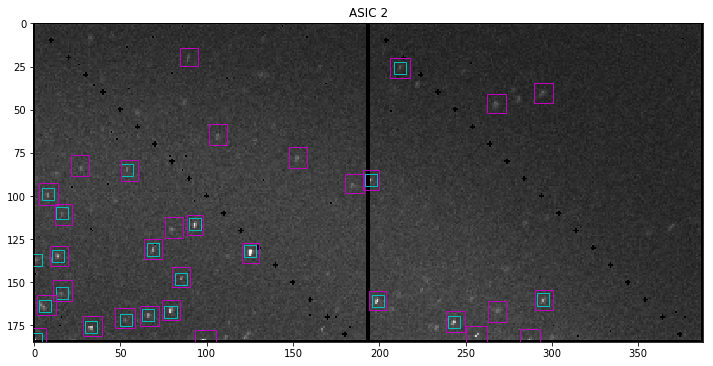

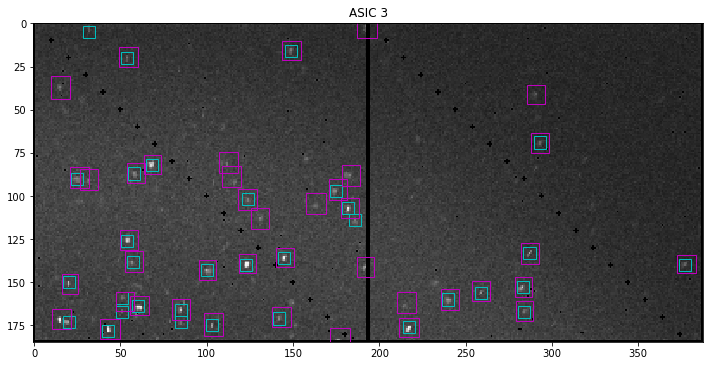

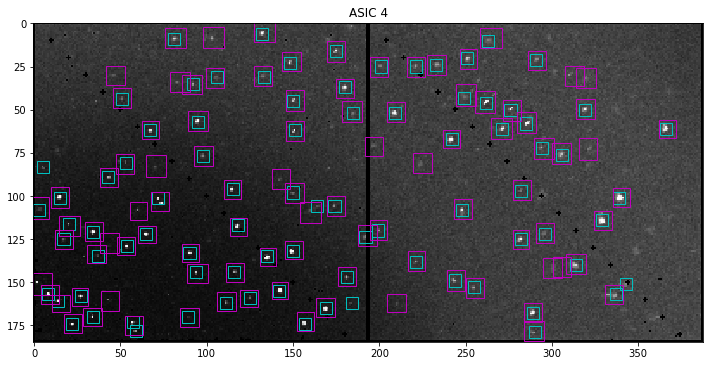

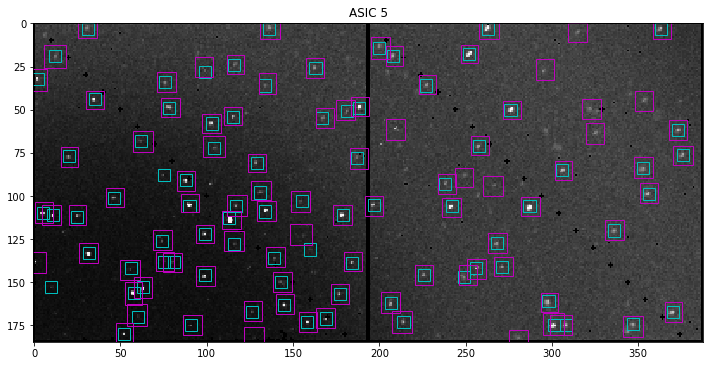

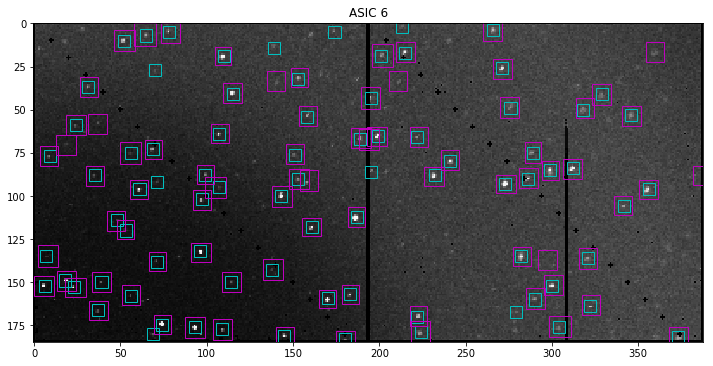

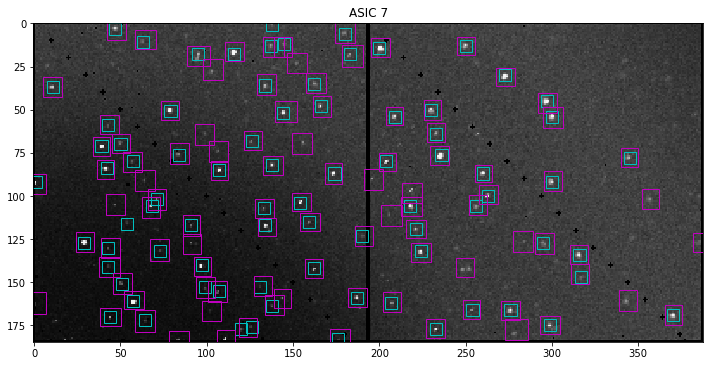

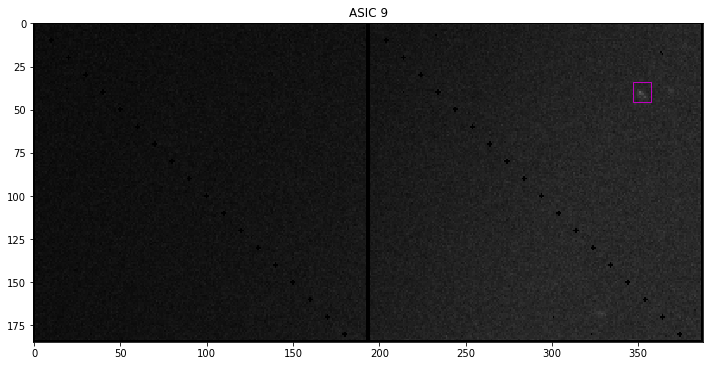

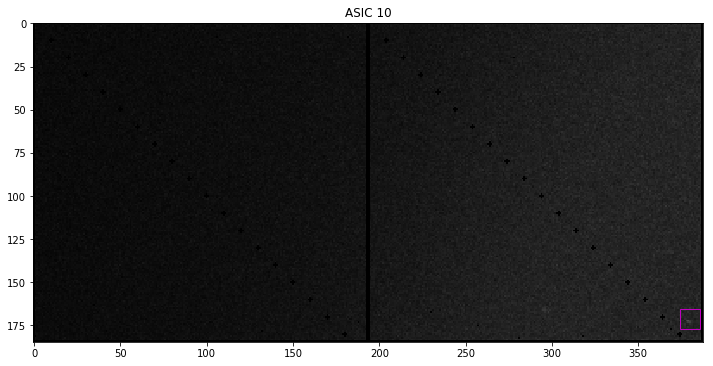

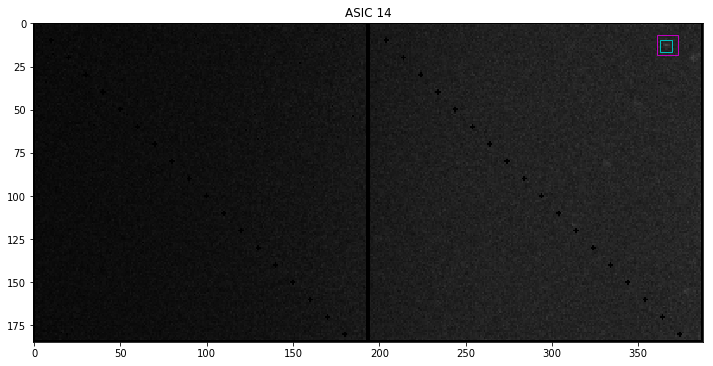

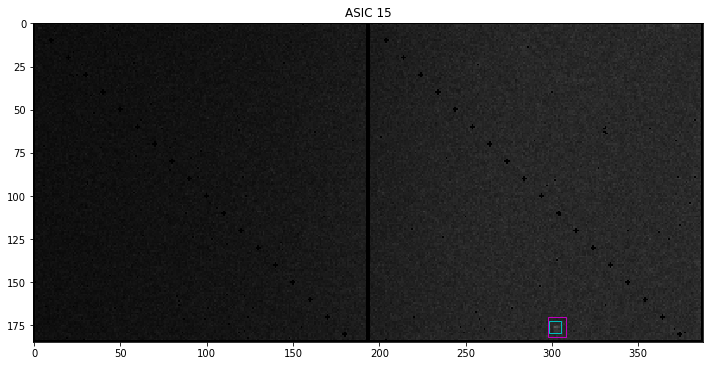

In [81]:
visualize(imgs, labels, results, plot_label=True, plot_box=True, indexes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [67]:
a, b, c, d = build_dataset( filename, dev_size = 1, total_size=10 )

hits: 1325
